# Full shape examples

In this notebook we will show how to perform full shape fits to data power spectrum, using Taylor expansion to speed up likelihood evaluation.
Look first at notebooks basic_examples.ipynb to get a flavor of *desilike* mechanisms.

## Fake power spectrum data

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from cosmoprimo.fiducial import DESI

cosmo = DESI()
edges = np.linspace(0., 0.3, 31)
k = (edges[:-1] + edges[1:]) / 2.
nmodes = 4. * np.pi / 3. * (edges[1:]**3 - edges[:-1]**3)
z = 1.
fo = cosmo.get_fourier()
pk = fo.pk_interpolator(of='delta_cb')(k, z=z)
b = 2.
f = fo.sigma8_z(z, of='theta_cb') / fo.sigma8_z(z, of='delta_cb')
shotnoise = 1 / 5e-4
volume = 1e10

ells = (0, 2, 4)
poles = []
poles.append((b**2 + 2. / 3. * f * b + 1. / 5. * f**2) * pk + shotnoise)
poles.append((4. / 3. * f * b + 4. / 7. * f**2) * pk)
poles.append(8. / 35 * f**2 * pk)
poles = np.array(poles, dtype='f8')

from pypower import PowerSpectrumStatistics
mean = PowerSpectrumStatistics(edges, k, poles, nmodes=nmodes, ells=ells, shotnoise_nonorm=shotnoise, statistic='multipole')
cov = [2. * (2. * np.pi)**3 / (2 * ell + 1) / (volume * nmodes) * poles[0]**2 for ell in ells]
cov = np.diag(np.concatenate(cov, axis=0))

rng = np.random.RandomState(seed=42)
mocks = []
for i in range(1000):
    tmp = mean.deepcopy()
    tmp.power_nonorm.flat[...] = rng.multivariate_normal(mean.power_nonorm.ravel(), cov)
    mocks.append(tmp)
data, mocks = mocks[0], mocks[1:]

## Full likelihood

In [2]:
from desilike.theories.galaxy_clustering import FullPowerSpectrumTemplate, KaiserTracerPowerSpectrumMultipoles
from desilike.observables.galaxy_clustering import ObservedTracerPowerSpectrumMultipoles
from desilike.likelihoods import GaussianLikelihood
from desilike.parameter import ParameterCollection
from desilike import setup_logging


template = FullPowerSpectrumTemplate(z=z, fiducial='DESI')
template.params = ParameterCollection({'Omega_m': {'prior': {'dist': 'uniform', 'limits': [0.05, 0.6]},
                                                   'ref': {'dist': 'uniform', 'limits': [0.30, 0.33]}, 'latex': '\Omega_{m}'},
                                       'A_s': {'prior': {'dist': 'uniform', 'limits': [1.5e-9, 3e-9]},
                                               'ref': {'dist': 'uniform', 'limits': [1.9e-9, 2.1e-9]}},
                                        'h': {'prior': {'dist': 'uniform', 'limits': [0.4, 0.9]},
                                              'ref': {'dist': 'uniform', 'limits': [0.65, 0.70]}}})
theory = KaiserTracerPowerSpectrumMultipoles(template=template)
observable = ObservedTracerPowerSpectrumMultipoles(data=data, mocks=mocks,
                                                   klim={0: [0.02, 0.2], 2: [0.02, 0.2]}, # fit monopole and quadrupole, between 0.02 and 0.2 h/Mpc
                                                   theory=theory)
likelihood = GaussianLikelihood(observables=[observable])



# NOTE: if we wanted to fit xi instead:
# theory = KaiserTracerCorrelationFunctionMultipoles(template=template)
# observable = ObservedTracerCorrelationFunction(data=data, mocks=mocks,
#                                                slim={0: [40., 160], 2: [40., 160]}, # fit monopole and quadrupole, between 0.02 and 0.2 h/Mpc
#                                                theory=theory)
# The rest would be the same

setup_logging()
likelihood()  # just to initialize

[000000.09] [0/1] 12-05 13:56  GaussianLikelihood        INFO     Covariance matrix with 36 points built from 999 observations.
[000000.09] [0/1] 12-05 13:56  GaussianLikelihood        INFO     ...resulting in Hartlap factor of 0.9629.
[000000.78] [0/1] 12-05 13:56  absl                      INFO     Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
[000000.78] [0/1] 12-05 13:56  absl                      INFO     Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
[000000.78] [0/1] 12-05 13:56  absl                      INFO     Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
[000000.79] [0/1] 12-05 13:56  absl                      INFO     Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
[000000.79] [0/1] 12-05 13:56  absl                      WARNING  No GPU/TPU found, falling back to CPU

-17.28933528289536

[000001.95] [0/1] 12-05 13:56  Emulator                  INFO     Varied parameters: ['Omega_m', 'A_s', 'h', 'b1', 'sn0'].
[000001.95] [0/1] 12-05 13:56  Emulator                  INFO     Found varying ['power'] and fixed ['k', 'ells'] outputs.
[000017.40] [0/1] 12-05 13:57  Emulator                  INFO     Diagnostics:
[000017.56] [0/1] 12-05 13:57  Emulator                  INFO     - mse of power is 0.000442 (square root = 0.021).
[000017.67] [0/1] 12-05 13:57  Emulator                  INFO     Saving _tests/kaiser_emulator.npy.
[000017.67] [0/1] 12-05 13:57  BaseConfig                INFO     Saving _tests/kaiser_emulator.yaml.


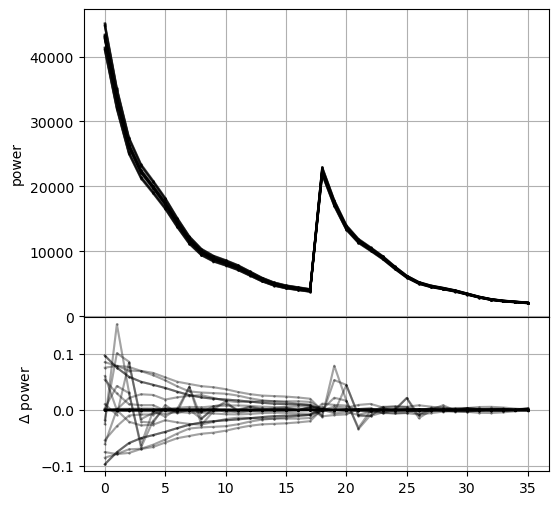

In [3]:
from desilike.emulators import Emulator, EmulatedCalculator, TaylorEmulatorEngine

emulator = Emulator(theory, engine=TaylorEmulatorEngine(order={'*': 2, 'sn0': 1}))  # order 2 except for sn0 (order 1 is enough)
emulator.set_samples()
emulator.fit()
emulator.check()
emulator.plot(name='power')

import os
base_dir = '_tests'
kaiser_emulator_fn = os.path.join(base_dir, 'kaiser_emulator.npy')
emulator.save(kaiser_emulator_fn)

## Sampling
Let us draw MC samples of the likelihood (actually posterior, including parameter priors).

In [4]:
from desilike.samplers import ZeusSampler

# Let's just update the observable's theory, no need to redefine the observable & likelihood
# (Internally the code will reinitialize all calculators that depend on observable)
observable.update(theory=emulator.to_calculator())

sampler = ZeusSampler(likelihood, save_fn='_tests/chain_fs_full_*.npy', seed=42)
sampler.run(check={'max_eigen_gr': 0.04})

[000018.08] [0/1] 12-05 13:57  GaussianLikelihood        INFO     Covariance matrix with 36 points built from 999 observations.
[000018.08] [0/1] 12-05 13:57  GaussianLikelihood        INFO     ...resulting in Hartlap factor of 0.9629.
[000018.09] [0/1] 12-05 13:57  ZeusSampler               INFO     Varied parameters: ['Omega_m', 'A_s', 'h', 'b1', 'sn0'].
[000018.21] [0/1] 12-05 13:57  root                      INFO     Initialising ensemble of 12 walkers...
[000070.62] [0/1] 12-05 13:57  Chain                     INFO     Saving _tests/chain_fs_full_0.npy.
[000070.62] [0/1] 12-05 13:57  ZeusSampler               INFO     Diagnostics:
[000070.63] [0/1] 12-05 13:57  ZeusSampler               INFO     - max eigen Gelman-Rubin - 1 is 1.18; not < 0.04.
[000070.63] [0/1] 12-05 13:57  ZeusSampler               INFO     - max diag Gelman-Rubin - 1 is 0.0401.
[000070.65] [0/1] 12-05 13:57  ZeusSampler               INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.0596.
[000070.65] [0/1

[000435.92] [0/1] 12-05 14:04  ZeusSampler               INFO     - max Geweke is 0.401.
[000435.92] [0/1] 12-05 14:04  ZeusSampler               INFO     - Geweke p-value is 0.312.
[000435.94] [0/1] 12-05 14:04  ZeusSampler               INFO     - (1200 iterations / integrated autocorrelation time) (reliable) is 50.3.
[000435.94] [0/1] 12-05 14:04  ZeusSampler               INFO     - max variation of integrated autocorrelation time is 0.239.
[000435.97] [0/1] 12-05 14:04  root                      INFO     Initialising ensemble of 12 walkers...
[000485.44] [0/1] 12-05 14:04  Chain                     INFO     Saving _tests/chain_fs_full_0.npy.
[000485.45] [0/1] 12-05 14:04  ZeusSampler               INFO     Diagnostics:
[000485.45] [0/1] 12-05 14:04  ZeusSampler               INFO     - max eigen Gelman-Rubin - 1 is 0.275; not < 0.04.
[000485.46] [0/1] 12-05 14:04  ZeusSampler               INFO     - max diag Gelman-Rubin - 1 is 0.023.
[000485.49] [0/1] 12-05 14:04  ZeusSampler   

[000851.89] [0/1] 12-05 14:10  ZeusSampler               INFO     - max eigen Gelman-Rubin - 1 is 0.017; < 0.04.
[000851.90] [0/1] 12-05 14:10  ZeusSampler               INFO     - max diag Gelman-Rubin - 1 is 0.00282.
[000851.94] [0/1] 12-05 14:10  ZeusSampler               INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.0157.
[000851.95] [0/1] 12-05 14:10  ZeusSampler               INFO     - max Geweke is 0.25.
[000851.95] [0/1] 12-05 14:10  ZeusSampler               INFO     - Geweke p-value is 0.361.
[000851.98] [0/1] 12-05 14:10  ZeusSampler               INFO     - (2400 iterations / integrated autocorrelation time) (reliable) is 148.
[000851.98] [0/1] 12-05 14:10  ZeusSampler               INFO     - max variation of integrated autocorrelation time is 0.0536.
[000852.01] [0/1] 12-05 14:10  root                      INFO     Initialising ensemble of 12 walkers...
[000904.74] [0/1] 12-05 14:11  Chain                     INFO     Saving _tests/chain_fs_full_0.npy.
[000904.

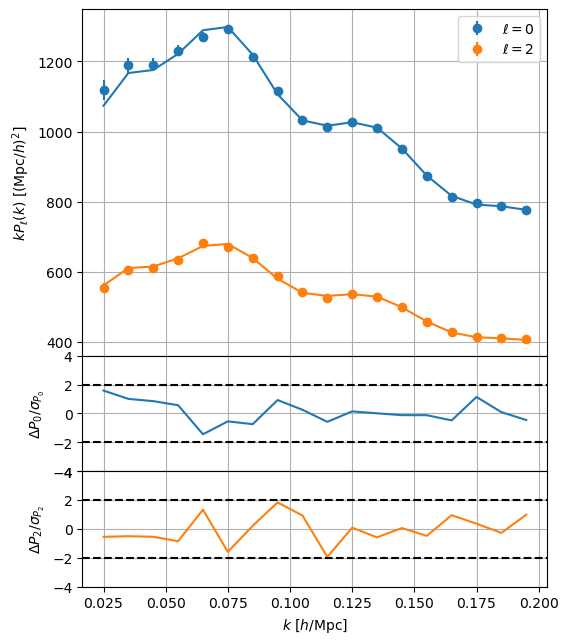

In [5]:
likelihood(**sampler.chains[0].choice(params=likelihood.varied_params))
observable.plot()
plt.show()

In [6]:
chain = sampler.chains[0].remove_burnin(0.5)
print(chain.to_stats(tablefmt='pretty'))

+---------+----------+----------+----------+---------+-------------------+-------------------+
|         |  argmax  |   mean   |  median  |   std   |  quantile:1sigma  |  interval:1sigma  |
+---------+----------+----------+----------+---------+-------------------+-------------------+
| Omega_m |  0.3105  |  0.3113  |  0.3110  | 0.0042  |  -0.0040/+0.0042  |  -0.0047/+0.0034  |
|   A_s   | 2.052e-9 | 2.060e-9 | 2.058e-9 | 5.0e-11 | -5.0e-11/+4.9e-11 | -5.7e-11/+4.3e-11 |
|    h    |  0.6824  |  0.6811  |  0.6814  | 0.0085  |  -0.0085/+0.0085  |  -0.0084/+0.0085  |
|   b1    |  1.989   |  1.989   |  1.989   |  0.013  |   -0.013/+0.012   |   -0.013/+0.012   |
|   sn0   |   20.    |    17    |    17    |   30.   |      -29/+29      |      -27/+31      |
+---------+----------+----------+----------+---------+-------------------+-------------------+


[000905.56] [0/1] 12-05 14:11  numexpr.utils             INFO     NumExpr defaulting to 8 threads.
Removed no burn in


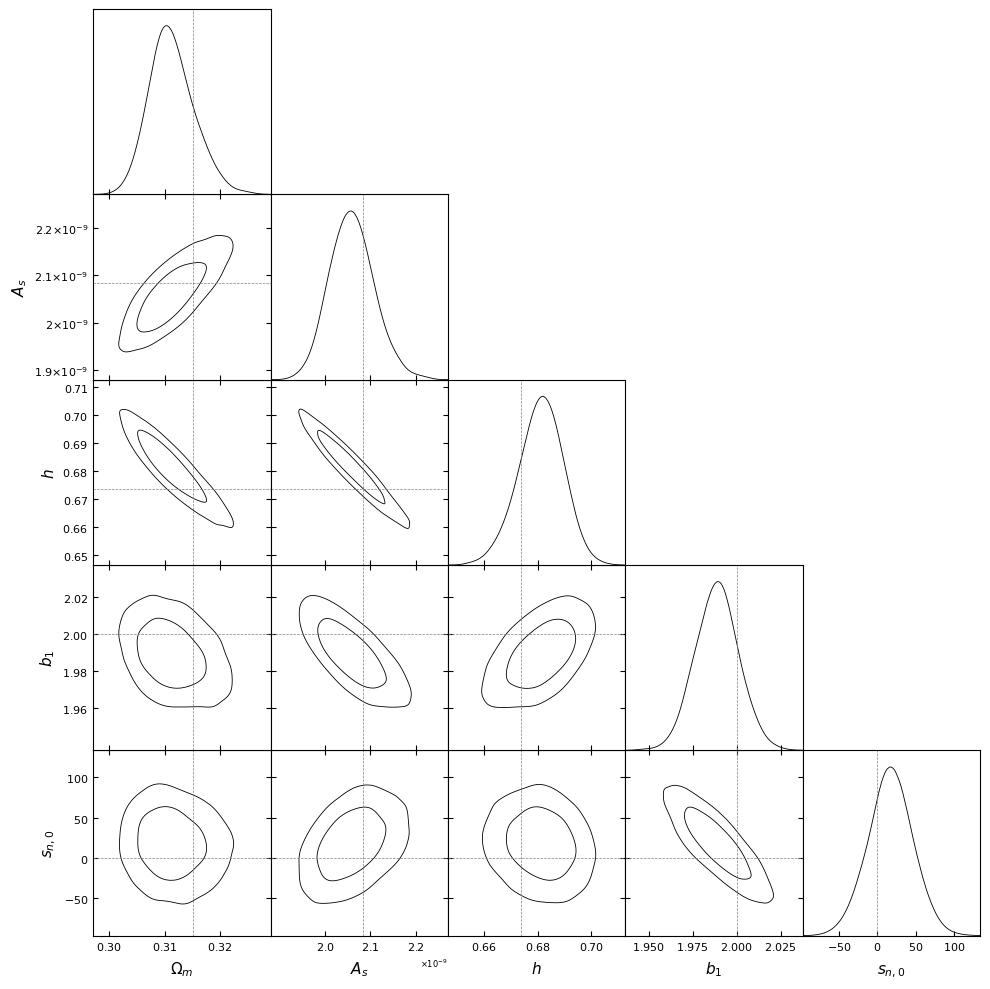

In [7]:
from desilike.samples import plotting
plotting.plot_triangle(chain, markers={'Omega_m': cosmo.Omega0_m, 'h': cosmo.h, 'A_s': cosmo.A_s, 'n_s': cosmo.n_s, 'b1': b, 'sn0': 0.})